In [ ]:
!pip install -q -U tensorflow-text
!pip install -q tf-models-official==2.4.0
!pip install contractions

     |████████████████████████████████| 4.9 MB 8.1 MB/s 
     |████████████████████████████████| 1.1 MB 7.2 MB/s 
     |████████████████████████████████| 213 kB 75.4 MB/s 
     |████████████████████████████████| 1.1 MB 69.3 MB/s 
     |████████████████████████████████| 47.6 MB 55 kB/s 
     |████████████████████████████████| 352 kB 73.4 MB/s 
     |████████████████████████████████| 99 kB 11.1 MB/s 
     |████████████████████████████████| 43 kB 2.3 MB/s 
     |████████████████████████████████| 321 kB 7.6 MB/s 
     |████████████████████████████████| 284 kB 64.1 MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.2-cp37-cp37m-linux_x86_64.whl size=85448 sha256=79c2e6c278db7967d8a3386104902668260f04490011ef33663389067ff5d001
  Stored in directory: /root/.cache/pip/wheels/25/19/a6/8f363d9939162782bb8439d886469756271abc01f76fbd790f
Successfully built pyahocorasick


In [ ]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

from keras.utils import np_utils

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer
import tensorflow.keras as keras
import tensorflow.keras.layers as layers

tf.get_logger().setLevel('ERROR')

##**Loading the MBTI Redddit dataset**

In [ ]:
df = pd.read_csv('mbti2_copy.csv',error_bad_lines=True, engine='python')
df.head(20)

,type,comment
0,entp,Yes! Personally I feel that as helpful as it i...
1,NaN,I guess I'd stick to being a lesbian so I woul...
2,unless someone has a skill I need they can be...,they'll never know you're only 2 feet behind ...
3,NaN,"What languages do you speak? Whoops, my bad fo..."
4,so I would try going to the school where you ...,but it doesn't rhyme anywhere and that makes ...
5,entp,It is just arguing semantics. To many on the c...
6,NaN,Come to Europe if you're interested. In many E...
7,because you need to really get some immersion...,many get stuck on B2
8,NaN,"Exactly, so I won't have to eat a dick, I knew..."
9,I heard spring 2015 a little while ago. Iahfy...,with his Xbox and all. Wait


**The shape of the Reddit data**

In [ ]:
df.shape

(15301, 2)

In [ ]:
reddit_data = df[df['type'].isin(['infj', 'entp', 'intp', 'intj', 'entj', 'enfj', 'infp', 'enfp','isfp', 'istp', 'isfj', 'istj', 'estp', 'esfp', 'estj', 'esfj'])]
print(reddit_data)
print("The shape of the data : ",reddit_data.shape)

       type                                            comment
0      entp  Yes! Personally I feel that as helpful as it i...
5      entp  It is just arguing semantics. To many on the c...
10     entp  Ooohhh okay, I thought there was something els...
13     intp  This was Blizzards way to slow down the meta. ...
16     intp  Thank you very much for the support. I am work...
...     ...                                                ...
15268  intp  Hoi!Heb je nog iemand nodig?  Ik kom uit Canad...
15271  intj  "Take care."A weird, shitty ending to the rela...
15272  esfj  $49.46 is how much it costs btw. You can pre-o...
15275  infj  You shouldn't use apps to base your assessment...
15278  infj  We've hanged out about 5 times actually. But t...

[3236 rows x 2 columns]
The shape of the data :  (3236, 2)


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


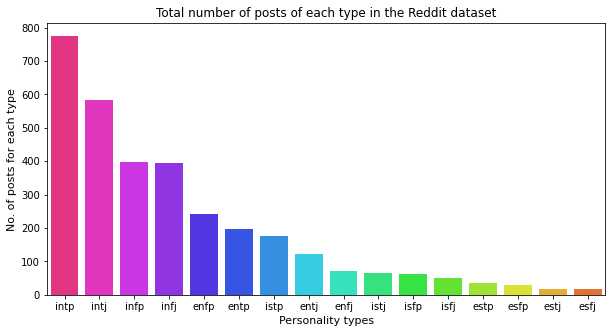

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

post_count = reddit_data ['type'].value_counts()
plt.figure(figsize=(10,5))
sns.barplot(post_count.index,post_count.values,alpha=0.9,palette='hsv_r')
plt.xlabel('Personality types', fontsize=11)
plt.ylabel('No. of posts for each type', fontsize=11)
plt.title('Total number of posts of each type in the Reddit dataset')
plt.show()

In [ ]:
import re
import nltk 
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('words')
words = set(nltk.corpus.words.words())
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
nltk.download('punkt')
import contractions

def preprocessing(posts):
         
        posts = re.sub('\|\|\|', ' ', posts)
        posts = re.sub('https?://\S+|www\.\S+', '', posts)
        posts = contractions.fix(posts)
        posts = posts.lower()
        posts = re.sub('[0-9]+', '', posts)
        posts = (re.sub(' +', ' ',(posts.replace('\\n','')))).strip()
        posts = re.sub(r'[\.+~*]', ".",posts)
        
        #Remove multiple fullstops
        #posts = re.sub(r'[^\w\s]','',posts)

        #Remove Non-words
        posts = re.sub(r'[^a-zA-Z\s]','',posts)

        #Remove multiple letter repeating words
        posts = re.sub(r'([a-z])\1{2,}[\s|\w]*','',posts)

        #filtering non-words
        posts = " ".join(word for word in nltk.wordpunct_tokenize(posts) if word.lower() in words or not word.isalpha())

        stop_words = stopwords.words("english")
        personality_words = ['infj', 'entp', 'intp', 'intj', 'entj', 'enfj', 'infp', 'enfp','isfp', 'istp', 'isfj', 'istj', 'estp', 'esfp', 'estj', 'esfj', 'mbti']
        stop_words.extend(personality_words)
        posts =  ' '.join([w for w in posts.split() if w not in stop_words])

        posts = ' '.join(word for word in posts.split() if len(word)>3)

        lemmatizer = WordNetLemmatizer()
        word_tokens = nltk.word_tokenize(posts)
        posts = ' '.join([lemmatizer.lemmatize(word) for word in word_tokens])        
                
        return posts

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
split_types = reddit_data['type'].str.split('',expand=True)
split_types = split_types.drop(split_types.columns[[0, 5]], axis=1)
split_types

,1,2,3,4
0,e,n,t,p
5,e,n,t,p
10,e,n,t,p
13,i,n,t,p
16,i,n,t,p
...,...,...,...,...
15268,i,n,t,p
15271,i,n,t,j
15272,e,s,f,j
15275,i,n,f,j


In [ ]:
data = [split_types[1], reddit_data["comment"]]
headers = ["types","posts"]

reddit_IE = pd.concat(data, axis=1, keys=headers)
reddit_IE = reddit_IE.reset_index(drop=True)

data = [split_types[2], reddit_data["comment"]]
headers = ["types", "posts"]

reddit_SN = pd.concat(data, axis=1, keys=headers)
reddit_SN = reddit_SN.reset_index(drop=True)

data = [split_types[3], reddit_data["comment"]]
headers = ["types", "posts"]

reddit_FT = pd.concat(data, axis=1, keys=headers)
reddit_FT = reddit_FT.reset_index(drop=True)

data = [split_types[4], reddit_data["comment"]]
headers = ["types", "posts"]

reddit_JP = pd.concat(data, axis=1, keys=headers)
reddit_JP = reddit_JP.reset_index(drop=True)

print(reddit_IE)
print(reddit_SN)
print(reddit_FT)
print(reddit_JP)

     types                                              posts
0        e  Yes! Personally I feel that as helpful as it i...
1        e  It is just arguing semantics. To many on the c...
2        e  Ooohhh okay, I thought there was something els...
3        i  This was Blizzards way to slow down the meta. ...
4        i  Thank you very much for the support. I am work...
...    ...                                                ...
3231     i  Hoi!Heb je nog iemand nodig?  Ik kom uit Canad...
3232     i  "Take care."A weird, shitty ending to the rela...
3233     e  $49.46 is how much it costs btw. You can pre-o...
3234     i  You shouldn't use apps to base your assessment...
3235     i  We've hanged out about 5 times actually. But t...

[3236 rows x 2 columns]
     types                                              posts
0        n  Yes! Personally I feel that as helpful as it i...
1        n  It is just arguing semantics. To many on the c...
2        n  Ooohhh okay, I thought there was 

In [ ]:
from google.colab import files

reddit_IE.to_csv("MBTI_Reddit_I_E.csv", index= False)
reddit_SN.to_csv("MBTI_Reddit_S_N.csv", index= False)
reddit_FT.to_csv("MBTI_Reddit_F_T.csv", index= False)
reddit_JP.to_csv("MBTI_Reddit_J_P.csv", index= False)

files.download("MBTI_Reddit_I_E.csv")
files.download("MBTI_Reddit_S_N.csv")
files.download("MBTI_Reddit_F_T.csv")
files.download("MBTI_Reddit_J_P.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
reddit_IE = pd.read_csv("MBTI_Reddit_I_E.csv")
print("The shape of binary dataset (I/E) : ", reddit_IE.shape)
reddit_IE

The shape of binary dataset (I/E) :  (3236, 2)


,types,posts
0,e,Yes! Personally I feel that as helpful as it i...
1,e,It is just arguing semantics. To many on the c...
2,e,"Ooohhh okay, I thought there was something els..."
3,i,This was Blizzards way to slow down the meta. ...
4,i,Thank you very much for the support. I am work...
...,...,...
3231,i,Hoi!Heb je nog iemand nodig? Ik kom uit Canad...
3232,i,"""Take care.""A weird, shitty ending to the rela..."
3233,e,$49.46 is how much it costs btw. You can pre-o...
3234,i,You shouldn't use apps to base your assessment...


In [ ]:
reddit_IE['types'].value_counts()

i    2506
e     730
Name: types, dtype: int64

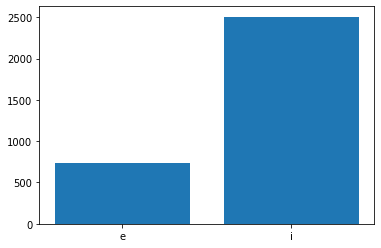

In [ ]:
classes = reddit_IE.types.unique()
counts = []

for i in classes:
  count = len(reddit_IE[reddit_IE.types==i])
  counts.append(count)

plt.bar(classes, counts)
plt.show()

In [ ]:
reddit_IE['cleaned_posts'] = reddit_IE['posts'].apply(preprocessing)

In [ ]:
labelencoder_IE = LabelEncoder()

reddit_IE['Encoded_labels'] = labelencoder_IE.fit_transform(reddit_IE['types'])
reddit_IE

,types,posts,cleaned_posts,Encoded_labels
0,e,Yes! Personally I feel that as helpful as it i...,personally feel helpful meticulously plan ofte...,0
1,e,It is just arguing semantics. To many on the c...,semantics many consumer beta production phase ...,0
2,e,"Ooohhh okay, I thought there was something els...",,0
3,i,This was Blizzards way to slow down the meta. ...,slow meta working intended turn turn lethal fo...,1
4,i,Thank you very much for the support. I am work...,thank much support working daily basis hope we...,1
...,...,...,...,...
3231,i,Hoi!Heb je nog iemand nodig? Ik kom uit Canad...,canada woon bent keep language learning can no...,1
3232,i,"""Take care.""A weird, shitty ending to the rela...",take weird ending relationship overall lot goo...,1
3233,e,$49.46 is how much it costs btw. You can pre-o...,much preorder true bear lake turn particular t...,0
3234,i,You shouldn't use apps to base your assessment...,base assessment certain group besides older ex...,1


In [ ]:
x= reddit_IE['cleaned_posts']
y= reddit_IE['Encoded_labels']

In [ ]:
y.value_counts()

1    2506
0     730
Name: Encoded_labels, dtype: int64

In [ ]:
reddit_IE = reddit_IE.sample(frac=1)

X = reddit_IE['cleaned_posts']
y = reddit_IE['Encoded_labels']


split_1 = int(0.7 * len(reddit_IE))
split_2 = int(0.85 * len(reddit_IE))

X_train1 = X[:split_1]
X_val1 = X[split_1:split_2]
X_test1 = X[split_2:]
y_train1 = y[:split_1]
y_val1 = y[split_1:split_2]
y_test1 = y[split_2:]
print("The shape of X_train : ",X_train1.shape)
print("The shape of y_train : ", y_train1.shape)
print("The shape of X_val : ",X_val1.shape)
print("The shape of y_val : ",y_val1.shape)
print("The shape of X_test : ",X_test1.shape)
print("The shape of y_test : ",y_test1.shape)

The shape of X_train :  (2265,)
The shape of y_train :  (2265,)
The shape of X_val :  (485,)
The shape of y_val :  (485,)
The shape of X_test :  (486,)
The shape of y_test :  (486,)


In [ ]:
y_train1_BM = np_utils.to_categorical(y_train1)
y_val1_BM = np_utils.to_categorical(y_val1)
y_test1_BM = np_utils.to_categorical(y_test1)

In [ ]:
bert_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'
bert_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4'

In [ ]:
num_class = len(labelencoder_IE.classes_)

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='inputs')
preprocessing_layer = hub.KerasLayer(bert_preprocess, name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(bert_encoder, trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)
output = outputs['pooled_output']
output = tf.keras.layers.Dropout(0.1)(output)
output = tf.keras.layers.Dense(num_class, activation='sigmoid', name='classifier')(output)
model = tf.keras.Model(text_input, output)
#model.summary()

In [ ]:
epochs = 50
batch_size = 32 

train_data_size = len(y_train1_BM)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = optimization.create_optimizer(
    3e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps, optimizer_type='adamw')

In [ ]:
loss = keras.losses.BinaryCrossentropy()
auc = keras.metrics.AUC(multi_label=True, curve="ROC")
metrics=[auc, keras.metrics.BinaryAccuracy(),keras.metrics.Precision(),keras.metrics.Recall()]

In [ ]:
from keras import callbacks
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 5, 
                                        restore_best_weights = True)

In [ ]:
model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
history = model.fit(
    X_train1, y_train1_BM,
    validation_data=(X_val1, y_val1_BM),
    epochs=epochs,
    batch_size=batch_size, callbacks =[earlystopping], verbose=2)

Epoch 1/50
71/71 - 157s - loss: 0.5829 - auc: 0.5076 - binary_accuracy: 0.7278 - precision: 0.7196 - recall: 0.7466 - val_loss: 0.5353 - val_auc: 0.5325 - val_binary_accuracy: 0.7732 - val_precision: 0.7732 - val_recall: 0.7732 - 157s/epoch - 2s/step
Epoch 2/50
71/71 - 132s - loss: 0.5411 - auc: 0.5325 - binary_accuracy: 0.7726 - precision: 0.7726 - recall: 0.7726 - val_loss: 0.5349 - val_auc: 0.5803 - val_binary_accuracy: 0.7732 - val_precision: 0.7732 - val_recall: 0.7732 - 132s/epoch - 2s/step
Epoch 3/50
71/71 - 132s - loss: 0.5358 - auc: 0.5486 - binary_accuracy: 0.7722 - precision: 0.7722 - recall: 0.7722 - val_loss: 0.5287 - val_auc: 0.5906 - val_binary_accuracy: 0.7732 - val_precision: 0.7732 - val_recall: 0.7732 - 132s/epoch - 2s/step
Epoch 4/50
71/71 - 132s - loss: 0.5097 - auc: 0.6495 - binary_accuracy: 0.7746 - precision: 0.7752 - recall: 0.7735 - val_loss: 0.5500 - val_auc: 0.5968 - val_binary_accuracy: 0.7722 - val_precision: 0.7727 - val_recall: 0.7711 - 132s/epoch - 2s/s

In [ ]:
loss1, auc1, accuracy1, precision1, recall1 = model.evaluate(X_test1, y_test1_BM, batch_size=32, verbose=False)

print("Testing Accuracy: ",accuracy1)
print("Loss : ",loss1)
print("Precision : ",precision1)
print("Recall : ",recall1)
print("AUC : ", auc1)

Testing Accuracy:  0.7818930149078369
Loss :  0.5297306180000305
Precision :  0.7818930149078369
Recall :  0.7818930149078369
AUC :  0.5094215869903564


In [ ]:
F1_IE = 2 * (precision1 * recall1) / (precision1 + recall1)
print("F1 score for Introvert/Extrovert(I/E): {:.4f}".format(F1_IE))

F1 score for Introvert/Extrovert(I/E): 0.7819


In [ ]:
def plot_history(history):

  history_dict = history.history
  #print(history_dict.keys())

  acc = history_dict['binary_accuracy']
  val_acc = history_dict['val_binary_accuracy']
  loss = history_dict['loss']
  val_loss = history_dict['val_loss']

  epochs = range(1, len(acc) + 1)
  plt.figure(figsize=(10, 6))


  plt.subplot(2, 1, 1)
  plt.plot(epochs, loss, 'r', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.legend()

  plt.subplot(2, 1, 2)
  plt.plot(epochs, acc, 'r', label='Training acc')
  plt.plot(epochs, val_acc, 'b', label='Validation acc')
  plt.title('Training and validation accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.legend(loc='upper left')
  plt.tight_layout()

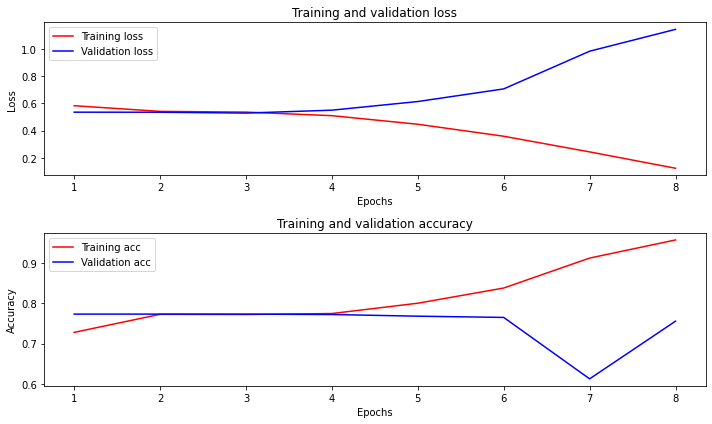

In [ ]:
plot_history(history)

In [ ]:
y_predicted1 = model.predict(X_test1)

In [ ]:
input =  "I like studying deep learning, playing football and my guitar, " \
     "and I love visit foreign cities all over the world."
sentences = np.asarray([input])

predict = model.predict(sentences)

print(predict)
print('Input text is ', 'MBTI type Introvert(I)' if labelencoder_IE.classes_[np.argmax(predict)]=='i' else 'MBTI type Extrovert(E)')

[[0.3969615 0.6249533]]
Input text is  MBTI type Introvert(I)


In [ ]:
input =  "I hate to attend meetings everyday"
sentences = np.asarray([input])

predict = model.predict(sentences)

print(predict)
print('Input text is ', 'MBTI type Introvert(I)' if labelencoder_IE.classes_[np.argmax(predict)]=='i' else 'MBTI type Extrovert(E)')

[[0.43593228 0.6609702 ]]
Input text is  MBTI type Introvert(I)


In [ ]:
model.save("reddit_I-E_model.h5")

In [ ]:
!ls reddit_I_E_model.h5

In [ ]:
reloaded_model_IE = tf.keras.models.load_model("reddit_I-E_model.h5", custom_objects={'KerasLayer':hub.KerasLayer , 'AdamWeightDecay': optimizer})

In [ ]:
input =  "I like studying deep learning, playing football and my guitar, " \
     "and I love visit foreign cities all over the world."
sentences = np.asarray([input])

predict = model.predict(sentences)

print(predict)
print('Input text is ', 'MBTI type Introvert(I)' if labelencoder_IE.classes_[np.argmax(predict)]=='i' else 'MBTI type Extrovert(E)')

[[0.3969615 0.6249533]]
Input text is  MBTI type Introvert(I)


In [ ]:
input =  "I hate to attend meetings everyday"
sentences = np.asarray([input])

predict = model.predict(sentences)

print(predict)
print('Input text is ', 'MBTI type Introvert(I)' if labelencoder_IE.classes_[np.argmax(predict)]=='i' else 'MBTI type Extrovert(E)')

[[0.43593228 0.6609702 ]]
Input text is  MBTI type Introvert(I)


In [ ]:
reddit_SN = pd.read_csv("MBTI_Reddit_S_N.csv")
reddit_SN.head()

In [ ]:
reddit_SN['cleaned_posts'] = reddit_SN['posts'].apply(preprocessing)

In [ ]:
labelencoder_SN = LabelEncoder()

reddit_SN['Encoded_labels'] = labelencoder_SN.fit_transform(reddit_SN['types'])
reddit_SN

,types,posts,cleaned_posts,Encoded_labels
0,n,Yes! Personally I feel that as helpful as it i...,personally feel helpful meticulously plan ofte...,0
1,n,It is just arguing semantics. To many on the c...,semantics many consumer beta production phase ...,0
2,n,"Ooohhh okay, I thought there was something els...",,0
3,n,This was Blizzards way to slow down the meta. ...,slow meta working intended turn turn lethal fo...,0
4,n,Thank you very much for the support. I am work...,thank much support working daily basis hope we...,0
...,...,...,...,...
3231,n,Hoi!Heb je nog iemand nodig? Ik kom uit Canad...,canada woon bent keep language learning can no...,0
3232,n,"""Take care.""A weird, shitty ending to the rela...",take weird ending relationship overall lot goo...,0
3233,s,$49.46 is how much it costs btw. You can pre-o...,much preorder true bear lake turn particular t...,1
3234,n,You shouldn't use apps to base your assessment...,base assessment certain group besides older ex...,0


In [ ]:
reddit_SN = reddit_SN.sample(frac=1)

X = reddit_SN['cleaned_posts']
y = reddit_SN['Encoded_labels']

split_1 = int(0.7 * len(reddit_SN))
split_2 = int(0.85 * len(reddit_SN))

X_train2 = X[:split_1]
X_val2 = X[split_1:split_2]
X_test2 = X[split_2:]
y_train2 = y[:split_1]
y_val2 = y[split_1:split_2]
y_test2 = y[split_2:]
print("The shape of X_train : ",X_train2.shape)
print("The shape of y_train : ", y_train2.shape)
print("The shape of X_val : ",X_val2.shape)
print("The shape of y_val : ",y_val2.shape)
print("The shape of X_test : ",X_test2.shape)
print("The shape of y_test : ",y_test2.shape)

The shape of X_train :  (2265,)
The shape of y_train :  (2265,)
The shape of X_val :  (485,)
The shape of y_val :  (485,)
The shape of X_test :  (486,)
The shape of y_test :  (486,)


In [ ]:
y_train2_BM = np_utils.to_categorical(y_train2)
y_val2_BM = np_utils.to_categorical(y_val2)
y_test2_BM = np_utils.to_categorical(y_test2)

In [ ]:
num_class = len(labelencoder_SN.classes_)

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='inputs')
preprocessing_layer = hub.KerasLayer(bert_preprocess, name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(bert_encoder, trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)
output = outputs['pooled_output']
output = tf.keras.layers.Dropout(0.1)(output)
output = tf.keras.layers.Dense(num_class, activation='sigmoid', name='classifier')(output)
model = tf.keras.Model(text_input, output)
#model.summary()

In [ ]:
epochs = 50
batch_size = 16 

train_data_size = len(y_train2_BM)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = optimization.create_optimizer(
    3e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps, optimizer_type='adamw')

In [ ]:
model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
history = model.fit(
    X_train2, y_train2_BM,
    validation_data=(X_val2, y_val2_BM),
    epochs=epochs,
    batch_size=batch_size, callbacks =[earlystopping], verbose=2)

Epoch 1/50
142/142 - 164s - loss: 0.4585 - auc: 0.7440 - binary_accuracy: 0.8308 - precision: 0.8321 - recall: 0.8288 - val_loss: 0.4246 - val_auc: 0.5756 - val_binary_accuracy: 0.8495 - val_precision: 0.8495 - val_recall: 0.8495 - 164s/epoch - 1s/step
Epoch 2/50
142/142 - 141s - loss: 0.4171 - auc: 0.5117 - binary_accuracy: 0.8592 - precision: 0.8592 - recall: 0.8592 - val_loss: 0.4469 - val_auc: 0.5799 - val_binary_accuracy: 0.8495 - val_precision: 0.8495 - val_recall: 0.8495 - 141s/epoch - 993ms/step
Epoch 3/50
142/142 - 140s - loss: 0.4162 - auc: 0.5171 - binary_accuracy: 0.8592 - precision: 0.8592 - recall: 0.8592 - val_loss: 0.4285 - val_auc: 0.6399 - val_binary_accuracy: 0.8495 - val_precision: 0.8495 - val_recall: 0.8495 - 140s/epoch - 988ms/step
Epoch 4/50
142/142 - 140s - loss: 0.4001 - auc: 0.6112 - binary_accuracy: 0.8587 - precision: 0.8578 - recall: 0.8600 - val_loss: 0.4146 - val_auc: 0.6413 - val_binary_accuracy: 0.8495 - val_precision: 0.8495 - val_recall: 0.8495 - 140

In [ ]:
loss2, auc2, accuracy2, precision2, recall2 = model.evaluate(X_test2, y_test2_BM, batch_size=16, verbose=False)

print("Testing Accuracy: ",accuracy2)
print("Loss : ",loss2)
print("Precision : ",precision2)
print("Recall : ",recall2)
print("AUC : ",auc2)

Testing Accuracy:  0.8765432238578796
Loss :  0.3744148015975952
Precision :  0.8765432238578796
Recall :  0.8765432238578796
AUC :  0.5720950365066528


In [ ]:
F1_SN = 2 * (precision2 * recall2) / (precision2 + recall2)
print("F1 score for Sensing/INtuition(S/N): {:.4f}".format(F1_SN))

F1 score for Sensing/INtuition(S/N): 0.8765


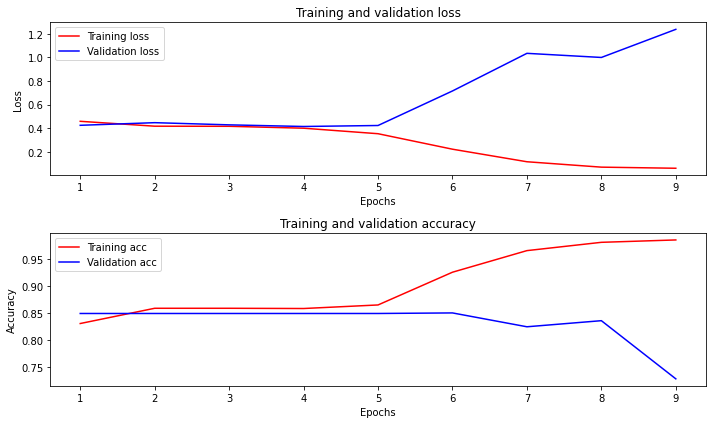

In [ ]:
plot_history(history)

In [ ]:
input =  "I like studying deep learning, playing football and my guitar, " \
     "and I love visit foreign cities all over the world."
sentences = np.asarray([input])

predict = model.predict(sentences)

print(predict)
print('Input text is ', 'MBTI type Sensing(S)' if labelencoder_SN.classes_[np.argmax(predict)]=='s' else 'MBTI type INtuition(N)')

[[0.74806523 0.15315393]]
Input text is  MBTI type INtuition(N)


In [ ]:
input =  "I hate to attend meetings everyday"
sentences = np.asarray([input])

predict = model.predict(sentences)

print(predict)
print('Input text is ', 'MBTI type Sensing(S)' if labelencoder_SN.classes_[np.argmax(predict)]=='s' else 'MBTI type INtuition(N)')

[[0.7677255 0.2973881]]
Input text is  MBTI type INtuition(N)


In [ ]:
model.save("reddit_S-N_model.h5")

In [ ]:
reloaded_model_SN = tf.keras.models.load_model("reddit_S-N_model.h5", custom_objects={'KerasLayer':hub.KerasLayer , 'AdamWeightDecay': optimizer})

In [ ]:
reddit_FT = pd.read_csv("MBTI_Reddit_F_T.csv")
reddit_FT.head()

,types,posts
0,t,Yes! Personally I feel that as helpful as it i...
1,t,It is just arguing semantics. To many on the c...
2,t,"Ooohhh okay, I thought there was something els..."
3,t,This was Blizzards way to slow down the meta. ...
4,t,Thank you very much for the support. I am work...


In [ ]:
reddit_FT['cleaned_posts'] = reddit_FT['posts'].apply(preprocessing)

In [ ]:
labelencoder_FT = LabelEncoder()

reddit_FT['Encoded_labels'] = labelencoder_FT.fit_transform(reddit_FT['types'])
reddit_FT

,types,posts,cleaned_posts,Encoded_labels
0,t,Yes! Personally I feel that as helpful as it i...,personally feel helpful meticulously plan ofte...,1
1,t,It is just arguing semantics. To many on the c...,semantics many consumer beta production phase ...,1
2,t,"Ooohhh okay, I thought there was something els...",,1
3,t,This was Blizzards way to slow down the meta. ...,slow meta working intended turn turn lethal fo...,1
4,t,Thank you very much for the support. I am work...,thank much support working daily basis hope we...,1
...,...,...,...,...
3231,t,Hoi!Heb je nog iemand nodig? Ik kom uit Canad...,canada woon bent keep language learning can no...,1
3232,t,"""Take care.""A weird, shitty ending to the rela...",take weird ending relationship overall lot goo...,1
3233,f,$49.46 is how much it costs btw. You can pre-o...,much preorder true bear lake turn particular t...,0
3234,f,You shouldn't use apps to base your assessment...,base assessment certain group besides older ex...,0


In [ ]:
reddit_FT = reddit_FT.sample(frac=1)
#print(binary_df1)

X = reddit_FT['cleaned_posts']
y = reddit_FT['Encoded_labels']


split_1 = int(0.7 * len(reddit_FT))
split_2 = int(0.85 * len(reddit_FT))

X_train3 = X[:split_1]
X_val3 = X[split_1:split_2]
X_test3 = X[split_2:]
y_train3 = y[:split_1]
y_val3 = y[split_1:split_2]
y_test3 = y[split_2:]
print("The shape of X_train : ",X_train3.shape)
print("The shape of y_train : ", y_train3.shape)
print("The shape of X_val : ",X_val3.shape)
print("The shape of y_val : ",y_val3.shape)
print("The shape of X_test : ",X_test3.shape)
print("The shape of y_test : ",y_test3.shape)

The shape of X_train :  (2265,)
The shape of y_train :  (2265,)
The shape of X_val :  (485,)
The shape of y_val :  (485,)
The shape of X_test :  (486,)
The shape of y_test :  (486,)


In [ ]:
y_train3_BM = np_utils.to_categorical(y_train3)
y_val3_BM = np_utils.to_categorical(y_val3)
y_test3_BM = np_utils.to_categorical(y_test3)

In [ ]:
num_class = len(labelencoder_FT.classes_)

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='inputs')
preprocessing_layer = hub.KerasLayer(bert_preprocess, name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(bert_encoder, trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)
output = outputs['pooled_output']
output = tf.keras.layers.Dropout(0.1)(output)
output = tf.keras.layers.Dense(num_class, activation='sigmoid', name='classifier')(output)
model3 = tf.keras.Model(text_input, output)
#model.summary()

In [ ]:
epochs = 50
batch_size = 16 

train_data_size = len(y_train3_BM)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = optimization.create_optimizer(
    3e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps, optimizer_type='adamw')

In [ ]:
model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
history = model.fit(
    X_train3, y_train3_BM,
    validation_data=(X_val3, y_val3_BM),
    epochs=epochs,
    batch_size=batch_size, callbacks =[earlystopping], verbose=2)

Epoch 1/50
142/142 - 154s - loss: 0.8468 - auc: 0.6151 - binary_accuracy: 0.5498 - precision: 0.5480 - recall: 0.5685 - val_loss: 0.6713 - val_auc: 0.5936 - val_binary_accuracy: 0.6010 - val_precision: 0.5984 - val_recall: 0.6144 - 154s/epoch - 1s/step
Epoch 2/50
142/142 - 140s - loss: 0.6686 - auc: 0.5654 - binary_accuracy: 0.6002 - precision: 0.5978 - recall: 0.6124 - val_loss: 0.6515 - val_auc: 0.6326 - val_binary_accuracy: 0.6010 - val_precision: 0.5992 - val_recall: 0.6103 - 140s/epoch - 988ms/step
Epoch 3/50
142/142 - 140s - loss: 0.6270 - auc: 0.6721 - binary_accuracy: 0.6539 - precision: 0.6533 - recall: 0.6556 - val_loss: 0.6489 - val_auc: 0.6416 - val_binary_accuracy: 0.6381 - val_precision: 0.6319 - val_recall: 0.6619 - 140s/epoch - 985ms/step
Epoch 4/50
142/142 - 139s - loss: 0.5598 - auc: 0.7674 - binary_accuracy: 0.7104 - precision: 0.7115 - recall: 0.7077 - val_loss: 0.7296 - val_auc: 0.6406 - val_binary_accuracy: 0.6330 - val_precision: 0.6375 - val_recall: 0.6165 - 139

In [ ]:
loss3,  auc3, accuracy3, precision3, recall3 = model.evaluate(X_test3, y_test3_BM, batch_size=32, verbose=False)

print("Testing Accuracy: ",accuracy3)
print("Loss : ",loss3)
print("Precision : ",precision3)
print("Recall : ",recall3)
print("AUC : ", auc3)

Testing Accuracy:  0.645061731338501
Loss :  0.6506267189979553
Precision :  0.6374269127845764
Recall :  0.6728395223617554
AUC :  0.6307475566864014


In [ ]:
F1_FT = 2 * (precision3 * recall3) / (precision3 + recall3)
print("F1 score for Feeling/Thinking(F/T): {:.4f}".format(F1_FT))

F1 score for Feeling/Thinking(F/T): 0.6547


In [ ]:
input =  "I like studying deep learning, playing football and my guitar, " \
     "and I love visit foreign cities all over the world."
sentences = np.asarray([input])

predict = model.predict(sentences)

print(predict)
print('Input text is ', 'MBTI type Feeling(F)' if labelencoder_FT.classes_[np.argmax(predict)]=='f' else 'MBTI type Thinking(T)')

[[0.5595951  0.29887295]]
Input text is  MBTI type Feeling(F)


In [ ]:
input =  "I hate to attend meetings everyday"
sentences = np.asarray([input])

predict = model.predict(sentences)

print(predict)
print('Input text is ', 'MBTI type Feeling(F)' if labelencoder_FT.classes_[np.argmax(predict)]=='f' else 'MBTI type Thinking(T)')

[[0.6034082  0.43796974]]
Input text is  MBTI type Feeling(F)


In [ ]:
model.save("reddit_F-T_model.h5")

In [ ]:
reloaded_model_FT = tf.keras.models.load_model("reddit_F-T_model.h5", custom_objects={'KerasLayer':hub.KerasLayer , 'AdamWeightDecay': optimizer})

In [ ]:
reddit_JP = pd.read_csv("MBTI_Reddit_J_P.csv")
reddit_JP

,types,posts
0,p,Yes! Personally I feel that as helpful as it i...
1,p,It is just arguing semantics. To many on the c...
2,p,"Ooohhh okay, I thought there was something els..."
3,p,This was Blizzards way to slow down the meta. ...
4,p,Thank you very much for the support. I am work...
...,...,...
3231,p,Hoi!Heb je nog iemand nodig? Ik kom uit Canad...
3232,j,"""Take care.""A weird, shitty ending to the rela..."
3233,j,$49.46 is how much it costs btw. You can pre-o...
3234,j,You shouldn't use apps to base your assessment...


In [ ]:
reddit_JP['cleaned_posts'] = reddit_JP['posts'].apply(preprocessing)

In [ ]:
labelencoder_JP = LabelEncoder()

reddit_JP['Encoded_labels'] = labelencoder_JP.fit_transform(reddit_JP['types'])
reddit_JP

,types,posts,cleaned_posts,Encoded_labels
0,p,Yes! Personally I feel that as helpful as it i...,personally feel helpful meticulously plan ofte...,1
1,p,It is just arguing semantics. To many on the c...,semantics many consumer beta production phase ...,1
2,p,"Ooohhh okay, I thought there was something els...",,1
3,p,This was Blizzards way to slow down the meta. ...,slow meta working intended turn turn lethal fo...,1
4,p,Thank you very much for the support. I am work...,thank much support working daily basis hope we...,1
...,...,...,...,...
3231,p,Hoi!Heb je nog iemand nodig? Ik kom uit Canad...,canada woon bent keep language learning can no...,1
3232,j,"""Take care.""A weird, shitty ending to the rela...",take weird ending relationship overall lot goo...,0
3233,j,$49.46 is how much it costs btw. You can pre-o...,much preorder true bear lake turn particular t...,0
3234,j,You shouldn't use apps to base your assessment...,base assessment certain group besides older ex...,0


In [ ]:
reddit_JP = reddit_JP.sample(frac=1)
#print(binary_df1)

X = reddit_JP['cleaned_posts']
y = reddit_JP['Encoded_labels']


split_1 = int(0.7 * len(reddit_JP))
split_2 = int(0.85 * len(reddit_JP))

X_train4 = X[:split_1]
X_val4 = X[split_1:split_2]
X_test4 = X[split_2:]
y_train4 = y[:split_1]
y_val4 = y[split_1:split_2]
y_test4 = y[split_2:]
print("The shape of X_train : ",X_train4.shape)
print("The shape of y_train : ", y_train4.shape)
print("The shape of X_val : ",X_val4.shape)
print("The shape of y_val : ",y_val4.shape)
print("The shape of X_test : ",X_test4.shape)
print("The shape of y_test : ",y_test4.shape)

The shape of X_train :  (2265,)
The shape of y_train :  (2265,)
The shape of X_val :  (485,)
The shape of y_val :  (485,)
The shape of X_test :  (486,)
The shape of y_test :  (486,)


In [ ]:
y_train4_BM = np_utils.to_categorical(y_train4)
y_val4_BM = np_utils.to_categorical(y_val4)
y_test4_BM = np_utils.to_categorical(y_test4)

In [ ]:
num_class = len(labelencoder_JP.classes_)

text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='inputs')
preprocessing_layer = hub.KerasLayer(bert_preprocess, name='preprocessing')
encoder_inputs = preprocessing_layer(text_input)
encoder = hub.KerasLayer(bert_encoder, trainable=True, name='BERT_encoder')
outputs = encoder(encoder_inputs)
output = outputs['pooled_output']
output = tf.keras.layers.Dropout(0.1)(output)
output = tf.keras.layers.Dense(num_class, activation='sigmoid', name='classifier')(output)
model3 = tf.keras.Model(text_input, output)
#model.summary()

In [ ]:
epochs = 50
batch_size = 16 

train_data_size = len(y_train4_BM)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = optimization.create_optimizer(
    3e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps, optimizer_type='adamw')

In [ ]:
model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
history = model.fit(
    X_train4, y_train4_BM,
    validation_data=(X_val4, y_val4_BM),
    epochs=epochs,
    batch_size=batch_size, callbacks =[earlystopping], verbose=2)

Epoch 1/50
142/142 - 153s - loss: 0.7029 - auc: 0.5400 - binary_accuracy: 0.5769 - precision: 0.5738 - recall: 0.5980 - val_loss: 0.6854 - val_auc: 0.5039 - val_binary_accuracy: 0.5763 - val_precision: 0.5758 - val_recall: 0.5794 - 153s/epoch - 1s/step
Epoch 2/50
142/142 - 140s - loss: 0.6762 - auc: 0.5466 - binary_accuracy: 0.5852 - precision: 0.5852 - recall: 0.5850 - val_loss: 0.6795 - val_auc: 0.5374 - val_binary_accuracy: 0.5763 - val_precision: 0.5743 - val_recall: 0.5897 - 140s/epoch - 985ms/step
Epoch 3/50
142/142 - 139s - loss: 0.6513 - auc: 0.6267 - binary_accuracy: 0.6168 - precision: 0.6172 - recall: 0.6150 - val_loss: 0.6971 - val_auc: 0.5551 - val_binary_accuracy: 0.5526 - val_precision: 0.5558 - val_recall: 0.5237 - 139s/epoch - 978ms/step
Epoch 4/50
142/142 - 140s - loss: 0.5534 - auc: 0.7754 - binary_accuracy: 0.7102 - precision: 0.7117 - recall: 0.7064 - val_loss: 0.8283 - val_auc: 0.5443 - val_binary_accuracy: 0.5000 - val_precision: 0.5000 - val_recall: 0.5093 - 140

In [ ]:
loss4, auc4, accuracy4, precision4, recall4 = model.evaluate(X_test4, y_test4_BM, batch_size=32, verbose=False)

print("Testing Accuracy: ",accuracy4)
print("Loss : ",loss4)
print("Precision : ",precision4)
print("Recall : ",recall4)
print("AUC : ",auc4)

Testing Accuracy:  0.6069958806037903
Loss :  0.6619077920913696
Precision :  0.6039999723434448
Recall :  0.6213991641998291
AUC :  0.6057231426239014


In [ ]:
F1_JP = 2 * (precision4 * recall4) / (precision4 + recall4)
print("F1 score for Judging/Perceiving(J/P): {:.4f}".format(F1_JP))

F1 score for Judging/Perceiving(J/P): 0.6126


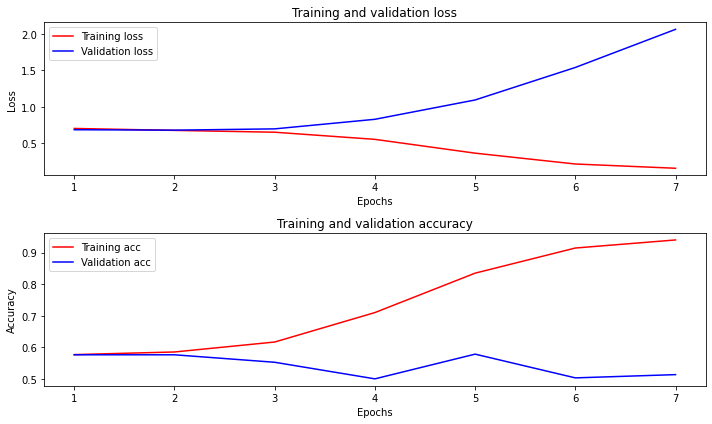

In [ ]:
plot_history(history)

In [ ]:
input =  "I like studying deep learning, playing football and my guitar, " \
     "and I love visit foreign cities all over the world."
sentences = np.asarray([input])

predict = model.predict(sentences)

print(predict)
print('Input text is ', 'MBTI type Perceiving(P)' if labelencoder_JP.classes_[np.argmax(predict)]=='p' else 'MBTI type Judging(J)')

[[0.4119194  0.48744604]]
Input text is  MBTI type Perceiving(P)


In [ ]:
input =  "I hate to attend meetings everyday"
sentences = np.asarray([input])

predict = model.predict(sentences)

print(predict)
print('Input text is ', 'MBTI type Perceiving(P)' if labelencoder_JP.classes_[np.argmax(predict)]=='p' else 'MBTI type Judging(J)')

[[0.46395648 0.56608236]]
Input text is  MBTI type Perceiving(P)


In [ ]:
model.save("reddit_J-P_model.h5")

In [ ]:
reloaded_model_JP = tf.keras.models.load_model("reddit_F-T_model.h5", custom_objects={'KerasLayer':hub.KerasLayer , 'AdamWeightDecay': optimizer})

In [ ]:
models = ["I-E model", "S-N model", "F-T model", "J-P model"]
accuracy = []
precision = []
recall = []
F1_score = []
auc = []
accuracy.append(accuracy1)
accuracy.append(accuracy2)
accuracy.append(accuracy3)
accuracy.append(accuracy4)
precision.append(precision1)
precision.append(precision2)
precision.append(precision3)
precision.append(precision4)
recall.append(recall1)
recall.append(recall2)
recall.append(recall3)
recall.append(recall4)
F1_score.append(F1_IE)
F1_score.append(F1_SN)
F1_score.append(F1_FT)
F1_score.append(F1_JP)
auc.append(auc1)
auc.append(auc2)
auc.append(auc3)
auc.append(auc4)

evaluation_metrics = pd.DataFrame()

evaluation_metrics['Models'] = models
evaluation_metrics['Accuracy'] = accuracy
evaluation_metrics['Precision'] = precision
evaluation_metrics['Recall'] = recall
evaluation_metrics['F1 Score'] = F1_score
evaluation_metrics['AUC'] = auc

In [ ]:
evaluation_metrics

,Models,Accuracy,Precision,Recall,F1 Score,AUC
0,I-E model,0.781893,0.781893,0.781893,0.781893,0.509422
1,S-N model,0.876543,0.876543,0.876543,0.876543,0.572095
2,F-T model,0.645062,0.637427,0.672840,0.654655,0.630748
3,J-P model,0.606996,0.604000,0.621399,0.612576,0.605723


In [ ]:
input =  "I like studying deep learning, playing football and my guitar, " \
     "and I love visit foreign cities all over the world."
sentences = np.asarray([input])

predict1 = reloaded_model_IE(sentences)
predict2 = reloaded_model_SN(sentences)
predict3 = reloaded_model_FT(sentences)
predict4 = reloaded_model_JP(sentences)

pred_types = []
scores = []
if labelencoder_IE.classes_[np.argmax(predict1)]=='i':
  pred_types.append('I')
  scores.append(predict1[0][1])
else:
  pred_types.append('E')
  scores.append(predict1[0][0])
if labelencoder_SN.classes_[np.argmax(predict2)]=='s':
  pred_types.append('S')
  scores.append(predict2[0][1])
else:
  pred_types.append('N')
  scores.append(predict2[0][0])
if labelencoder_FT.classes_[np.argmax(predict3)]=='t':
  pred_types.append('T')
  scores.append(predict3[0][1])
else:
  pred_types.append('F')
  scores.append(predict3[0][0])
if labelencoder_JP.classes_[np.argmax(predict4)]=='p':
  pred_types.append('P')
  scores.append(predict4[0][1])
else:
  pred_types.append('J')
  scores.append(predict4[0][0])
print('-- comment: ',sentences)
print('\n-- personality: ', pred_types)
print('\n-- scores:', scores)


-- comment:  ['I like studying deep learning, playing football and my guitar, and I love visit foreign cities all over the world.']

-- personality:  ['I', 'N', 'F', 'J']

-- scores: [<tf.Tensor: shape=(), dtype=float32, numpy=0.62495327>, <tf.Tensor: shape=(), dtype=float32, numpy=0.7480651>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5595951>, <tf.Tensor: shape=(), dtype=float32, numpy=0.5595951>]
